## ML модели 



### Импорты

In [52]:
# S3
import boto3
import optuna
import pandas as pd
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import (  # можно заменить на любимый классификатор
    LogisticRegression,
)
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

from mlds23_authorship_identification.preprocessing import prepare_text

### Загрузка данных

In [2]:
session = boto3.session.Session()

# splitted_data/splitted_df_1000.csv
# splitted_data/splitted_df_2000.csv
# splitted_data/splitted_df_3000.csv

s3 = session.client(
    service_name="s3",
    endpoint_url="https://storage.yandexcloud.net",
    aws_access_key_id="YCAJErlaldUmioGbHQSqJ70MR",
    aws_secret_access_key="YCPSba_JgloNYSNWcnKO2CYCEB8PFR1Iwgr2jIUy",
    region_name="ru-cental1",
)

BUCKET_NAME = "mlds23-authorship-identification"
BUCKET_DIR = "splitted_data/"
FILENAME = "splitted_df.csv"
# s3.download_file(Filename="data/" + FILENAME, Bucket=BUCKET_NAME, Key=BUCKET_DIR + FILENAME)
# загружает в локальную директорию, потом отдельно надо считывать
for i in range(1, 4):
    FNAME = f"splitted_df_{i}000.csv"
#    s3.download_file(Filename="data/" + FNAME, Bucket=BUCKET_NAME, Key=BUCKET_DIR + FNAME)

In [3]:
df = pd.read_csv("./data/split_3000_train.csv")
df_test = pd.read_csv("./data/split_3000_test.csv")
print(df.shape), print(df_test.shape)
df.head()

(1794, 4)
(399, 4)


,Unnamed: 0,target,text,book
0,0,6,"Узкими горными тропинками , от одного дачного ...",raw_data/aleksandr_kuprin_belyj_pudel'.txt
1,1,6,в вечных скитаниях : пуделя Арто и маленького ...,raw_data/aleksandr_kuprin_belyj_pudel'.txt
2,2,6,", когда весь Крым наполняется нарядной , богат...",raw_data/aleksandr_kuprin_belyj_pudel'.txt
3,3,6,"махали на них с балконов руками , в третьих пр...",raw_data/aleksandr_kuprin_belyj_pudel'.txt
4,4,6,"запыленных кипарисов , похожих на длинные черн...",raw_data/aleksandr_kuprin_belyj_pudel'.txt


In [4]:
X = df["text"]
X_test = df_test["text"]
y = df["target"]
y_test = df_test["target"]

## Предобработка и кодирование признаков

- исходим из предположения что знаки препинания являются важными признаками, поэтому закодируем некоторые из них в слова
- закодируем слова как часть речи, для частей речи имеющих падеж добавим падеж (сущ, прил, местоимение), для частей речи имеющих спряжение добавим спряжение. Формат - ЧАСТЬРЕЧИ_ПАДЕЖ 

(пример `"Мама. Мыла раму папе"` -> `'S,жен,од PNT V,несов,пе S,жен,неод S,муж,од'`)


Идея в принципе не нова - в частности похожий подход встречается в статьях

О.В. КУКУШКИНА, А.А.ПОЛИКАРПОВ, Д.В. ХМЕЛЁВ - ОПРЕДЕЛЕНИЕ АВТОРСТВА ТЕКСТА С ИСПОЛЬЗОВАНИЕМ БУКВЕННОЙ И ГРАММАТИЧЕСКОЙ ИНФОРМАЦИИ

https://www.philol.msu.ru/~lex/khmelev/published/gramcodes/gramcodeswin.html#tth_sEc2

Кижаева Наталья Александровна, Шалымов Дмитрий Сергеевич

ОПРЕДЕЛЕНИЕ АВТОРСКОГО СТИЛЯ ТЕКСТОВ НА ОСНОВЕ СТАТИСТИЧЕСКОГО ПОДХОДА ДВУХВЫБОРОЧНОГО ТЕСТИРОВАНИЯ И МЕТОДА K -БЛИЖАЙШИХ СОСЕДЕЙ (Компьютерные инструменты в образовании, 2015 No 5: 14–23)

In [5]:
# X_f = prepare_text(X, full=True)
# X_f_test = prepare_text(X_test, full=True)
# X_b = prepare_text(X, full=False)
# X_b_test = prepare_text(X_test, full=False)

In [6]:
# X_f = pd.DataFrame(X_f, columns = ['text'])
# X_f_test = pd.DataFrame(X_f_test, columns = ['text'])
# X_b = pd.DataFrame(X_b, columns = ['text'])
# X_b_test = pd.DataFrame(X_b_test, columns = ['text'])

In [7]:
# X_f.to_csv('./data/f_prepared_df_3000_newsplit.csv')
# X_f_test.to_csv('./data/f_prepared_df_3000_newsplit_test.csv')
# X_b.to_csv('./data/b_prepared_df_3000_newsplit.csv')
# X_b_test.to_csv('./data/b_prepared_df_3000_newsplit_test.csv')

In [8]:
X_f = pd.read_csv("./data/f_prepared_df_3000_newsplit.csv")
X_f_test = pd.read_csv("./data/f_prepared_df_3000_newsplit_test.csv")
X_b = pd.read_csv("./data/b_prepared_df_3000_newsplit.csv")
X_b_test = pd.read_csv("./data/b_prepared_df_3000_newsplit_test.csv")

In [9]:
X_f = X_f[["text"]]
X_f_test = X_f_test[["text"]]
X_b = X_b[["text"]]
X_b_test = X_b_test[["text"]]

# Эксперименты с линейными моделями

#### Подготовка BOW и обучение простейшей линейной модели на BOW

сначала на урезанных граммах



In [15]:
myvec = CountVectorizer(
    ngram_range=(1, 3),
    stop_words=None,
    lowercase=False,
    encoding="utf-8",
    token_pattern=r"(?u)\b[a-zA-Zа-яА-ЯёЁ0-9,=90|\-]+\b",
)

X_b_cv = myvec.fit_transform(X_b["text"])
X_b_cv_test = myvec.transform(X_b_test["text"])
# myvec.vocabulary_.items()

In [16]:
scorer = make_scorer(f1_score, average="weighted")

clf = LogisticRegression(random_state=42, max_iter=1200)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_b_cv, y, cv=cv_strategy, scoring=scorer)

print("Средняя F1-мера (weighted) по кросс-валидации: {:.2f}".format(scores.mean()))

Средняя F1-мера (weighted) по кросс-валидации: 0.85


In [17]:
# f1 на тесте
clf = LogisticRegression(random_state=42, max_iter=1200)
clf.fit(X_b_cv, y)
y_pred = clf.predict(X_b_cv_test)
f1_test = f1_score(y_test, y_pred, average="weighted")
print("На тесте f1-мера (weighted):", f1_test)

На тесте f1-мера (weighted): 0.715092419814165


Теперь на расширенных граммах

In [23]:
myvec = CountVectorizer(
    ngram_range=(1, 3),
    stop_words=None,
    lowercase=False,
    encoding="utf-8",
    token_pattern=r"(?u)\b[a-zA-Zа-яА-ЯёЁ0-9,=90|\-]+\b",
)

X_f_cv = myvec.fit_transform(X_f["text"])
X_f_cv_test = myvec.transform(X_f_test["text"])
# myvec.vocabulary_.items()

In [19]:
scorer = make_scorer(f1_score, average="weighted")

clf = LogisticRegression(random_state=42, max_iter=1200)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_f_cv, y, cv=cv_strategy, scoring=scorer)

print("Средняя F1-мера (weighted) по кросс-валидации: {:.2f}".format(scores.mean()))

Средняя F1-мера (weighted) по кросс-валидации: 0.86


In [24]:
# f1 на тесте
clf = LogisticRegression(random_state=42, max_iter=1200)
clf.fit(X_f_cv, y)
y_pred = clf.predict(X_f_cv_test)
f1_test = f1_score(y_test, y_pred, average="weighted")
print("На тесте f1-мера (weighted):", f1_test)

На тесте f1-мера (weighted): 0.723693378522833


#### Обучимся по схеме TF-IDF

In [25]:
vec = TfidfVectorizer(ngram_range=(1, 3))
X_f_tf = vec.fit_transform(X_f["text"])

scorer = make_scorer(f1_score, average="weighted")

clf = LogisticRegression(random_state=42, max_iter=1200)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_f_tf, y, cv=cv_strategy, scoring=scorer)

print("Средняя F1-мера (weighted) по кросс-валидации: {:.2f}".format(scores.mean()))

Средняя F1-мера (weighted) по кросс-валидации: 0.37


In [26]:
# f1 на тесте
clf = LogisticRegression(random_state=42, max_iter=1200)
clf.fit(X_f_tf, y)
y_pred = clf.predict(vec.transform(X_f_test["text"]))
f1_test = f1_score(y_test, y_pred, average="weighted")
print("На тесте f1-мера (weighted):", f1_test)

На тесте f1-мера (weighted): 0.2975289165381088


In [27]:
vec = TfidfVectorizer(ngram_range=(1, 3))
X_b_tf = vec.fit_transform(X_b["text"])

scorer = make_scorer(f1_score, average="weighted")

clf = LogisticRegression(random_state=42, max_iter=1200)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_b_tf, y, cv=cv_strategy, scoring=scorer)

print("Средняя F1-мера (weighted) по кросс-валидации: {:.2f}".format(scores.mean()))

Средняя F1-мера (weighted) по кросс-валидации: 0.53


In [28]:
# f1 на тесте
clf = LogisticRegression(random_state=42, max_iter=1200)
clf.fit(X_b_tf, y)
y_pred = clf.predict(vec.transform(X_b_test["text"]))
f1_test = f1_score(y_test, y_pred, average="weighted")
print("На тесте f1-мера (weighted):", f1_test)

На тесте f1-мера (weighted): 0.41180234581458325


# Выводы по линейным моделям

Линейные модели на простом BOW в целом дают неплохой результат по метрике f1 - модель на урезанных граммах работает чуть хуже чем на полных, TF-IDF полностью проваливается - что в общем-то объяснимо, мы же авторство определяем а не тематическим моделированием занимаемся

# Попробую подружить это все с Catboost

сначала на параметрах по умолчанию и на полном датасете с урезанными граммами


In [29]:
scorer = make_scorer(f1_score, average="weighted")
model = CatBoostClassifier(silent=True)
cvs_f1 = cross_val_score(model, X_b_cv, y, cv=5, scoring=scorer, n_jobs=-1).mean()

In [30]:
print(cvs_f1)

0.6815595710307475


In [33]:
model = CatBoostClassifier(silent=True)
model.fit(X_b_cv, y)
y_pred = model.predict(X_b_cv_test)
f1_test = f1_score(y_test, y_pred, average="weighted")
print("На тесте f1-мера (weighted):", f1_test)

На тесте f1-мера (weighted): 0.6346215430935443


качество на полном наборе признаков для CatboostClassifier `0.6346215430935443` - прямо скажем не очень по сравн5ению с линейной моделью

вообще катбуст на больших матрицах работает долго и плохо, поэтому сделаю понижение размерности методом PCA

In [35]:
dispesion_dict_b = {}
dispesion_dict_f = {}

for i in [10, 20, 30, 40, 50, 100, 150, 200, 500]:
    pca = PCA(n_components=i, svd_solver="arpack")
    X_b_cv_pca = pca.fit_transform(X_b_cv)
    X_b_cv_pca_test = pca.transform(X_b_cv_test)

    dispesion_dict_b[i] = sum(pca.explained_variance_ratio_)
    X_f_cv_pca = pca.fit_transform(X_f_cv)
    X_f_cv_pca_test = pca.transform(X_f_cv_test)

    dispesion_dict_f[i] = sum(pca.explained_variance_ratio_)

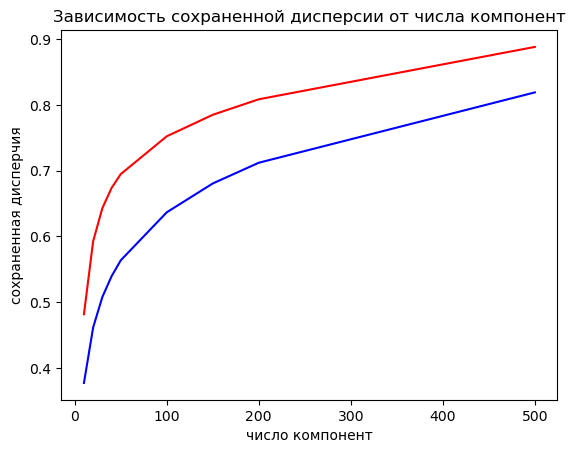

In [36]:
plt.figure()

plt.title("Зависимость сохраненной дисперсии от числа компонент")
plt.plot(dispesion_dict_b.keys(), dispesion_dict_b.values(), c="red")
plt.plot(dispesion_dict_f.keys(), dispesion_dict_f.values(), c="blue")

plt.xlabel("число компонент")
plt.ylabel("сохраненная дисперчия")
plt.show()

Видим что для хорошего результата должно хватить 300-500 первых компонент

In [37]:
pca = PCA(n_components=300, svd_solver="arpack")
X_b_cv_pca = pca.fit_transform(X_b_cv)

## Настройка Catboot (optuna)

In [38]:
scorer = make_scorer(f1_score, average="weighted")


def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
        "max_depth": trial.suggest_int("border_count", 1, 10),
    }

    model = CatBoostClassifier(**params, silent=True)
    cvs_f1 = cross_val_score(model, X_b_cv_pca, y, cv=5, scoring=scorer, n_jobs=-1).mean()
    print("cvs_f1: ", cvs_f1)
    return cvs_f1


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2024-02-29 02:56:39,475] A new study created in memory with name: no-name-a11b7e94-8f4b-48b1-bca2-00e2277af719
[I 2024-02-29 02:57:10,646] Trial 0 finished with value: 0.4452299841453874 and parameters: {'iterations': 241, 'learning_rate': 0.026253225068657755, 'l2_leaf_reg': 0.04079796423794623, 'border_count': 3}. Best is trial 0 with value: 0.4452299841453874.


cvs_f1:  0.4452299841453874


[I 2024-02-29 04:35:53,431] Trial 1 finished with value: 0.3850061695508577 and parameters: {'iterations': 270, 'learning_rate': 0.03368142795906269, 'l2_leaf_reg': 0.23230302450310716, 'border_count': 10}. Best is trial 0 with value: 0.4452299841453874.


cvs_f1:  0.3850061695508577


[I 2024-02-29 04:36:03,706] Trial 2 finished with value: 0.5327199423077984 and parameters: {'iterations': 428, 'learning_rate': 0.07100172717867796, 'l2_leaf_reg': 0.0011589257581291741, 'border_count': 1}. Best is trial 2 with value: 0.5327199423077984.


cvs_f1:  0.5327199423077984


[I 2024-02-29 04:38:09,438] Trial 3 finished with value: 0.6042932021234266 and parameters: {'iterations': 457, 'learning_rate': 0.16219043155261925, 'l2_leaf_reg': 0.006095048072504868, 'border_count': 4}. Best is trial 3 with value: 0.6042932021234266.


cvs_f1:  0.6042932021234266


[I 2024-02-29 05:35:35,568] Trial 4 finished with value: 0.45879862795188425 and parameters: {'iterations': 321, 'learning_rate': 0.07146024131097835, 'l2_leaf_reg': 0.0032679474180794805, 'border_count': 9}. Best is trial 3 with value: 0.6042932021234266.


cvs_f1:  0.45879862795188425


[I 2024-02-29 05:44:37,680] Trial 5 finished with value: 0.5254273020466225 and parameters: {'iterations': 235, 'learning_rate': 0.09617597812712608, 'l2_leaf_reg': 0.46171505160801685, 'border_count': 7}. Best is trial 3 with value: 0.6042932021234266.


cvs_f1:  0.5254273020466225


[I 2024-02-29 05:50:52,324] Trial 6 finished with value: 0.5477420610437405 and parameters: {'iterations': 436, 'learning_rate': 0.031023229923340848, 'l2_leaf_reg': 1.073463954859143, 'border_count': 6}. Best is trial 3 with value: 0.6042932021234266.


cvs_f1:  0.5477420610437405


[I 2024-02-29 06:41:53,008] Trial 7 finished with value: 0.3645200992197382 and parameters: {'iterations': 285, 'learning_rate': 0.012571455411701188, 'l2_leaf_reg': 0.08568766822862353, 'border_count': 9}. Best is trial 3 with value: 0.6042932021234266.


cvs_f1:  0.3645200992197382


[I 2024-02-29 06:44:55,429] Trial 8 finished with value: 0.4457832988613129 and parameters: {'iterations': 278, 'learning_rate': 0.014046077630984954, 'l2_leaf_reg': 0.02183761630058956, 'border_count': 5}. Best is trial 3 with value: 0.6042932021234266.


cvs_f1:  0.4457832988613129


[I 2024-02-29 07:04:42,473] Trial 9 finished with value: 0.40830135946853 and parameters: {'iterations': 230, 'learning_rate': 0.0375383395486289, 'l2_leaf_reg': 0.0038110749112238397, 'border_count': 8}. Best is trial 3 with value: 0.6042932021234266.


cvs_f1:  0.40830135946853


[I 2024-02-29 07:05:10,709] Trial 10 finished with value: 0.5341174957165118 and parameters: {'iterations': 101, 'learning_rate': 0.17566583286098847, 'l2_leaf_reg': 7.014150993724178, 'border_count': 4}. Best is trial 3 with value: 0.6042932021234266.


cvs_f1:  0.5341174957165118


[I 2024-02-29 07:12:15,432] Trial 11 finished with value: 0.6160458094798533 and parameters: {'iterations': 497, 'learning_rate': 0.16355856842972372, 'l2_leaf_reg': 1.8478491911138304, 'border_count': 6}. Best is trial 11 with value: 0.6160458094798533.


cvs_f1:  0.6160458094798533


[I 2024-02-29 07:12:43,491] Trial 12 finished with value: 0.6117824295124673 and parameters: {'iterations': 498, 'learning_rate': 0.1968820513864568, 'l2_leaf_reg': 6.334007093935406, 'border_count': 2}. Best is trial 11 with value: 0.6160458094798533.


cvs_f1:  0.6117824295124673


[I 2024-02-29 07:12:55,942] Trial 13 finished with value: 0.5552259648569426 and parameters: {'iterations': 497, 'learning_rate': 0.12003130006860199, 'l2_leaf_reg': 8.638026560402322, 'border_count': 1}. Best is trial 11 with value: 0.6160458094798533.


cvs_f1:  0.5552259648569426


[I 2024-02-29 07:13:39,581] Trial 14 finished with value: 0.6151856177065304 and parameters: {'iterations': 359, 'learning_rate': 0.18838845607708526, 'l2_leaf_reg': 2.099749783265241, 'border_count': 3}. Best is trial 11 with value: 0.6160458094798533.


cvs_f1:  0.6151856177065304


[I 2024-02-29 07:17:31,438] Trial 15 finished with value: 0.6061099216302297 and parameters: {'iterations': 355, 'learning_rate': 0.11243242746689491, 'l2_leaf_reg': 1.4294527639613126, 'border_count': 5}. Best is trial 11 with value: 0.6160458094798533.


cvs_f1:  0.6061099216302297


[I 2024-02-29 07:18:15,631] Trial 16 finished with value: 0.5827446832110986 and parameters: {'iterations': 360, 'learning_rate': 0.06798441465476796, 'l2_leaf_reg': 1.7252058969778694, 'border_count': 3}. Best is trial 11 with value: 0.6160458094798533.


cvs_f1:  0.5827446832110986


[I 2024-02-29 07:23:50,106] Trial 17 finished with value: 0.5561093420273425 and parameters: {'iterations': 391, 'learning_rate': 0.05281475808210356, 'l2_leaf_reg': 0.41321902416184175, 'border_count': 6}. Best is trial 11 with value: 0.6160458094798533.


cvs_f1:  0.5561093420273425


[I 2024-02-29 07:30:56,029] Trial 18 finished with value: 0.38209767502966513 and parameters: {'iterations': 185, 'learning_rate': 0.02188603918810856, 'l2_leaf_reg': 3.1530449023143903, 'border_count': 7}. Best is trial 11 with value: 0.6160458094798533.


cvs_f1:  0.38209767502966513


[I 2024-02-29 07:31:45,499] Trial 19 finished with value: 0.620914395773473 and parameters: {'iterations': 403, 'learning_rate': 0.12494909622278769, 'l2_leaf_reg': 0.16303118040835743, 'border_count': 3}. Best is trial 19 with value: 0.620914395773473.


cvs_f1:  0.620914395773473


[I 2024-02-29 07:33:37,544] Trial 20 finished with value: 0.6069791857852688 and parameters: {'iterations': 410, 'learning_rate': 0.1309702518978046, 'l2_leaf_reg': 0.13332388539195053, 'border_count': 4}. Best is trial 19 with value: 0.620914395773473.


cvs_f1:  0.6069791857852688


[I 2024-02-29 07:34:22,528] Trial 21 finished with value: 0.6177739383631268 and parameters: {'iterations': 367, 'learning_rate': 0.1367508256001792, 'l2_leaf_reg': 0.8115156333675098, 'border_count': 3}. Best is trial 19 with value: 0.620914395773473.


cvs_f1:  0.6177739383631268


[I 2024-02-29 07:34:49,026] Trial 22 finished with value: 0.5976722136399838 and parameters: {'iterations': 470, 'learning_rate': 0.08695350488516744, 'l2_leaf_reg': 0.6582880725307003, 'border_count': 2}. Best is trial 19 with value: 0.620914395773473.


cvs_f1:  0.5976722136399838


[I 2024-02-29 07:35:11,047] Trial 23 finished with value: 0.5901509057360872 and parameters: {'iterations': 391, 'learning_rate': 0.14376076519179115, 'l2_leaf_reg': 0.2641791223294588, 'border_count': 2}. Best is trial 19 with value: 0.620914395773473.


cvs_f1:  0.5901509057360872


[I 2024-02-29 07:38:42,165] Trial 24 finished with value: 0.5777236394881602 and parameters: {'iterations': 322, 'learning_rate': 0.1028571287220747, 'l2_leaf_reg': 0.08670506606904832, 'border_count': 5}. Best is trial 19 with value: 0.620914395773473.


cvs_f1:  0.5777236394881602


[I 2024-02-29 07:56:13,389] Trial 25 finished with value: 0.5733819290898512 and parameters: {'iterations': 459, 'learning_rate': 0.138358171677915, 'l2_leaf_reg': 0.7440136482549596, 'border_count': 7}. Best is trial 19 with value: 0.620914395773473.


cvs_f1:  0.5733819290898512


[I 2024-02-29 07:57:57,092] Trial 26 finished with value: 0.5596931526498488 and parameters: {'iterations': 377, 'learning_rate': 0.051170177758127926, 'l2_leaf_reg': 4.125101159783158, 'border_count': 4}. Best is trial 19 with value: 0.620914395773473.


cvs_f1:  0.5596931526498488


[I 2024-02-29 08:02:36,511] Trial 27 finished with value: 0.5485306964121318 and parameters: {'iterations': 327, 'learning_rate': 0.0894926605164632, 'l2_leaf_reg': 0.03768292619039988, 'border_count': 6}. Best is trial 19 with value: 0.620914395773473.


cvs_f1:  0.5485306964121318


[I 2024-02-29 08:03:28,594] Trial 28 finished with value: 0.6132617222144442 and parameters: {'iterations': 427, 'learning_rate': 0.15867139773769987, 'l2_leaf_reg': 0.17280560510841492, 'border_count': 3}. Best is trial 19 with value: 0.620914395773473.


cvs_f1:  0.6132617222144442


[I 2024-02-29 08:03:55,795] Trial 29 finished with value: 0.5866527322347246 and parameters: {'iterations': 482, 'learning_rate': 0.07804534710224106, 'l2_leaf_reg': 0.01903863047264629, 'border_count': 2}. Best is trial 19 with value: 0.620914395773473.


cvs_f1:  0.5866527322347246


In [39]:
print("Best hyperparameters:", study.best_params)
print("Best f1:", study.best_value)

Best hyperparameters: {'iterations': 403, 'learning_rate': 0.12494909622278769, 'l2_leaf_reg': 0.16303118040835743, 'border_count': 3}
Best f1: 0.620914395773473


### Подбором параметров для CatBoost сильно улучшить модель не получилось, хотя работало примерно часов 20 

возможно если бы аптюнили на полном наборе признаков - было бы лучше но мы этого на текущем круге сансары не узнаем потому что очень долго.

`Best hyperparameters: {'iterations': 403, 'learning_rate': 0.12494909622278769, 'l2_leaf_reg': 0.16303118040835743, 'border_count': 3}
Best f1: 0.620914395773473`

### RandomForest 

In [40]:
scorer = make_scorer(f1_score, average="weighted")

rfc = RandomForestClassifier(n_estimators=800)
cvs_f1 = cross_val_score(rfc, X_f_cv, y, cv=5, scoring=scorer, n_jobs=-1).mean()
print(cvs_f1)

0.3715402172649144


результат не впечатляет. пробуем аптюнить

In [41]:
scorer = make_scorer(f1_score, average="weighted")


def objective(trial):
    params = {
        "n_estimators": trial.suggest_categorical(
            "n_estimators", choices=[100, 300, 600, 900, 1200, 1500]
        ),
        "max_depth": trial.suggest_int("max_depth", 1, 500),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 200, log=True),
        "criterion": trial.suggest_categorical(
            "criterion", choices=["gini", "entropy", "log_loss"]
        ),
        "ccp_alpha": trial.suggest_float("border_count", 0.0, 0.1),
    }

    model = RandomForestClassifier(**params)
    cvs_f1 = cross_val_score(model, X_f_cv, y, cv=5, scoring=scorer, n_jobs=-1).mean()
    print("cvs_f1: ", cvs_f1)
    return cvs_f1


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2024-02-29 11:55:30,127] A new study created in memory with name: no-name-a2759df0-3535-44a0-98c7-bcac093f8fc1
[I 2024-02-29 11:55:49,382] Trial 0 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 1500, 'max_depth': 330, 'min_samples_split': 134, 'criterion': 'entropy', 'border_count': 0.04797376097297706}. Best is trial 0 with value: 0.08959216495454334.


cvs_f1:  0.08959216495454334


[I 2024-02-29 11:55:53,807] Trial 1 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 300, 'max_depth': 461, 'min_samples_split': 57, 'criterion': 'entropy', 'border_count': 0.07969988467979479}. Best is trial 0 with value: 0.08959216495454334.


cvs_f1:  0.08959216495454334


[I 2024-02-29 11:56:20,974] Trial 2 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 900, 'max_depth': 84, 'min_samples_split': 16, 'criterion': 'log_loss', 'border_count': 0.0470643793625172}. Best is trial 0 with value: 0.08959216495454334.


cvs_f1:  0.08959216495454334


[I 2024-02-29 11:56:28,313] Trial 3 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 100, 'max_depth': 129, 'min_samples_split': 3, 'criterion': 'gini', 'border_count': 0.088776211582944}. Best is trial 0 with value: 0.08959216495454334.


cvs_f1:  0.08959216495454334


[I 2024-02-29 11:56:48,984] Trial 4 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 1500, 'max_depth': 52, 'min_samples_split': 80, 'criterion': 'entropy', 'border_count': 0.08122067002314037}. Best is trial 0 with value: 0.08959216495454334.


cvs_f1:  0.08959216495454334


[I 2024-02-29 11:57:05,834] Trial 5 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 1200, 'max_depth': 397, 'min_samples_split': 119, 'criterion': 'gini', 'border_count': 0.01979140742777621}. Best is trial 0 with value: 0.08959216495454334.


cvs_f1:  0.08959216495454334


[I 2024-02-29 11:57:35,570] Trial 6 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 600, 'max_depth': 159, 'min_samples_split': 7, 'criterion': 'log_loss', 'border_count': 0.07414268409318868}. Best is trial 0 with value: 0.08959216495454334.


cvs_f1:  0.08959216495454334


[I 2024-02-29 11:57:42,738] Trial 7 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 300, 'max_depth': 208, 'min_samples_split': 45, 'criterion': 'gini', 'border_count': 0.031181924507899174}. Best is trial 0 with value: 0.08959216495454334.


cvs_f1:  0.08959216495454334


[I 2024-02-29 11:58:20,336] Trial 8 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 1500, 'max_depth': 402, 'min_samples_split': 21, 'criterion': 'entropy', 'border_count': 0.05422278833001037}. Best is trial 0 with value: 0.08959216495454334.


cvs_f1:  0.08959216495454334


[I 2024-02-29 11:58:33,258] Trial 9 finished with value: 0.09747385683464908 and parameters: {'n_estimators': 300, 'max_depth': 33, 'min_samples_split': 12, 'criterion': 'gini', 'border_count': 0.009545747773259472}. Best is trial 9 with value: 0.09747385683464908.


cvs_f1:  0.09747385683464908


[I 2024-02-29 11:58:51,061] Trial 10 finished with value: 0.3543327068460911 and parameters: {'n_estimators': 300, 'max_depth': 24, 'min_samples_split': 2, 'criterion': 'gini', 'border_count': 4.156846099287806e-05}. Best is trial 10 with value: 0.3543327068460911.


cvs_f1:  0.3543327068460911


[I 2024-02-29 11:58:54,664] Trial 11 finished with value: 0.11073472788400256 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 2, 'criterion': 'gini', 'border_count': 0.008646898317002964}. Best is trial 10 with value: 0.3543327068460911.


cvs_f1:  0.11073472788400256


[I 2024-02-29 11:59:15,322] Trial 12 finished with value: 0.3615247470138968 and parameters: {'n_estimators': 300, 'max_depth': 29, 'min_samples_split': 2, 'criterion': 'gini', 'border_count': 0.0012667413396045945}. Best is trial 12 with value: 0.3615247470138968.


cvs_f1:  0.3615247470138968


[I 2024-02-29 11:59:34,991] Trial 13 finished with value: 0.22245943052182687 and parameters: {'n_estimators': 300, 'max_depth': 270, 'min_samples_split': 4, 'criterion': 'gini', 'border_count': 0.004929716019363526}. Best is trial 12 with value: 0.3615247470138968.


cvs_f1:  0.22245943052182687


[I 2024-02-29 11:59:42,816] Trial 14 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 100, 'max_depth': 117, 'min_samples_split': 2, 'criterion': 'gini', 'border_count': 0.02828739692420393}. Best is trial 12 with value: 0.3615247470138968.


cvs_f1:  0.08959216495454334


[I 2024-02-29 12:00:38,515] Trial 15 finished with value: 0.36581414675850044 and parameters: {'n_estimators': 900, 'max_depth': 192, 'min_samples_split': 5, 'criterion': 'gini', 'border_count': 0.0010970559958258165}. Best is trial 15 with value: 0.36581414675850044.


cvs_f1:  0.36581414675850044


[I 2024-02-29 12:01:26,748] Trial 16 finished with value: 0.21988925172561052 and parameters: {'n_estimators': 900, 'max_depth': 219, 'min_samples_split': 6, 'criterion': 'log_loss', 'border_count': 0.02048742854846049}. Best is trial 15 with value: 0.36581414675850044.


cvs_f1:  0.21988925172561052


[I 2024-02-29 12:02:12,264] Trial 17 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 900, 'max_depth': 294, 'min_samples_split': 8, 'criterion': 'gini', 'border_count': 0.03757289469635601}. Best is trial 15 with value: 0.36581414675850044.


cvs_f1:  0.08959216495454334


[I 2024-02-29 12:03:31,280] Trial 18 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 1200, 'max_depth': 174, 'min_samples_split': 4, 'criterion': 'gini', 'border_count': 0.06085881139943564}. Best is trial 15 with value: 0.36581414675850044.


cvs_f1:  0.08959216495454334


[I 2024-02-29 12:03:44,345] Trial 19 finished with value: 0.2389325408401183 and parameters: {'n_estimators': 600, 'max_depth': 91, 'min_samples_split': 29, 'criterion': 'log_loss', 'border_count': 0.014373549538159733}. Best is trial 15 with value: 0.36581414675850044.


cvs_f1:  0.2389325408401183


[I 2024-02-29 12:04:41,766] Trial 20 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 900, 'max_depth': 331, 'min_samples_split': 4, 'criterion': 'gini', 'border_count': 0.03762054764060612}. Best is trial 15 with value: 0.36581414675850044.


cvs_f1:  0.08959216495454334


[I 2024-02-29 12:05:05,062] Trial 21 finished with value: 0.3673615204806674 and parameters: {'n_estimators': 300, 'max_depth': 52, 'min_samples_split': 2, 'criterion': 'gini', 'border_count': 0.0009182938332930469}. Best is trial 21 with value: 0.3673615204806674.


cvs_f1:  0.3673615204806674


[I 2024-02-29 12:05:25,743] Trial 22 finished with value: 0.3460174561960144 and parameters: {'n_estimators': 300, 'max_depth': 70, 'min_samples_split': 3, 'criterion': 'gini', 'border_count': 0.001522186157954535}. Best is trial 21 with value: 0.3673615204806674.


cvs_f1:  0.3460174561960144


[I 2024-02-29 12:06:33,927] Trial 23 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 900, 'max_depth': 146, 'min_samples_split': 2, 'criterion': 'gini', 'border_count': 0.017879959501569093}. Best is trial 21 with value: 0.3673615204806674.


cvs_f1:  0.08959216495454334


[I 2024-02-29 12:06:56,995] Trial 24 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 300, 'max_depth': 206, 'min_samples_split': 3, 'criterion': 'gini', 'border_count': 0.01176067096891476}. Best is trial 21 with value: 0.3673615204806674.


cvs_f1:  0.08959216495454334


[I 2024-02-29 12:07:14,860] Trial 25 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 1200, 'max_depth': 6, 'min_samples_split': 10, 'criterion': 'gini', 'border_count': 0.026759025415573113}. Best is trial 21 with value: 0.3673615204806674.


cvs_f1:  0.08959216495454334


[I 2024-02-29 12:07:53,299] Trial 26 finished with value: 0.36712954833504224 and parameters: {'n_estimators': 600, 'max_depth': 109, 'min_samples_split': 5, 'criterion': 'gini', 'border_count': 0.0001450483413950528}. Best is trial 21 with value: 0.3673615204806674.


cvs_f1:  0.36712954833504224


[I 2024-02-29 12:08:32,940] Trial 27 finished with value: 0.08959216495454334 and parameters: {'n_estimators': 600, 'max_depth': 103, 'min_samples_split': 5, 'criterion': 'gini', 'border_count': 0.09654176239236333}. Best is trial 21 with value: 0.3673615204806674.


cvs_f1:  0.08959216495454334


[I 2024-02-29 12:08:56,459] Trial 28 finished with value: 0.28508511964157174 and parameters: {'n_estimators': 600, 'max_depth': 171, 'min_samples_split': 12, 'criterion': 'entropy', 'border_count': 0.008498359682794897}. Best is trial 21 with value: 0.3673615204806674.


cvs_f1:  0.28508511964157174


[I 2024-02-29 12:09:33,280] Trial 29 finished with value: 0.22089411865933323 and parameters: {'n_estimators': 600, 'max_depth': 259, 'min_samples_split': 5, 'criterion': 'log_loss', 'border_count': 0.021886225637876434}. Best is trial 21 with value: 0.3673615204806674.


cvs_f1:  0.22089411865933323


In [42]:
print("Best hyperparameters:", study.best_params)
print("Best f1:", study.best_value)

Best hyperparameters: {'n_estimators': 300, 'max_depth': 52, 'min_samples_split': 2, 'criterion': 'gini', 'border_count': 0.0009182938332930469}
Best f1: 0.3673615204806674


### Резюме: наилучший результат по-преждему у линейной модели обученной на BOW из полных грамматических форм

можно завернуть это все в Pipeline

# Заворачиваем в Pipeline

заворачиваем лучшую на данный момент модель - а именно логистическую регрессию на полных граммах 

In [64]:
class TextTransformer:
    def __init__(self, full=True):
        """
        кодировка текста, заменяет слова грамматическими формами и кодирует знаки препинания
        Args:
            full (bool, optional): тип кодировки грамм. Сокращенный или расширенный. Defaults to True.
        """
        self.full = full

    def fit(self, X, y):
        return self

    def transform(self, X, y=None):
        return prepare_text(X, full=self.full)

    def fit_transform(self, X, y):
        return self.transform(X, y)


if __name__ == "__main__":
    import doctest

    doctest.testmod()

In [65]:
pline = Pipeline(
    [
        ("transformer", TextTransformer(full=True)),
        (
            "vectorizer",
            CountVectorizer(
                ngram_range=(1, 3),
                stop_words=None,
                lowercase=False,
                encoding="utf-8",
                token_pattern=r"(?u)\b[a-zA-Zа-яА-ЯёЁ0-9,=90|\-]+\b",
            ),
        ),
        ("model", LogisticRegression(random_state=42, max_iter=1200)),
    ]
)

In [66]:
pline.fit(X, y)

Pipeline(steps=[('transformer',
                 <__main__.TextTransformer object at 0x7f7b73f77450>),
                ('vectorizer',
                 CountVectorizer(lowercase=False, ngram_range=(1, 3),
                                 token_pattern='(?u)\\b[a-zA-Zа-яА-ЯёЁ0-9,=90|\\-]+\\b')),
                ('model', LogisticRegression(max_iter=1200, random_state=42))])

In [67]:
y_pred = pline.predict(X_test)
f1_test = f1_score(y_test, y_pred, average="weighted")
print("На тесте f1-мера (weighted):", f1_test)

На тесте f1-мера (weighted): 0.723693378522833


# Резюме

Били испробованы линейные модели, бустинг и случайный лес, для ускорения процесса обучения пробовал применять 
понижение размерности (PCA), таже для оптимизации catboost и random forest применялась optuna (правда получить результат лучший чем у линейной модели не получилось)

по итогам лучший результат остается за линейной моделью на расширенном кодировании грамматических признаках

итоговый результат лучшей модели на кросс-валидации - `0.86`, на отложенной выборке ("честный сплит" - 
выборка в которую не попали произведения на которых обучались) `0.72`

#### лучшая модель завернута в pipeline